In [1]:
#import Libraries
import nltk
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
!pip3 install torch torchvision torchaudio
!pip install torchtext

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
from torchtext import data
device = torch.device("cuda")
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import torch.nn.functional as F
from torch.nn import BatchNorm1d

from transformers import AdamW


from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Preprocessing

Preprocess test and train data by removing stopwords,punctuations and converting all the words to lower case

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
                                                text  stars
0  Went for lunch and found that my burger was me...    2.0
1  I needed a new tires for my wife's car. They h...    5.0
2  Jim Woltman who works at Goleta Honda is 5 sta...    5.0
3  Been here a few times to get some shrimp.  The...    4.0
4  This is one fantastic place to eat whether you...    5.0
Data after preprocessing:
                                                text  stars  sentiment  \
0  went lunch found burger meh obvious focus burg...    2.0          0   
1  needed new tires wifes car special order next ...    5.0          2   
2  jim woltman works goleta honda 5 stars knowled...    5.0          2   
3  times get shrimp theyve got nice selection dif...    4.0          2   
4  o

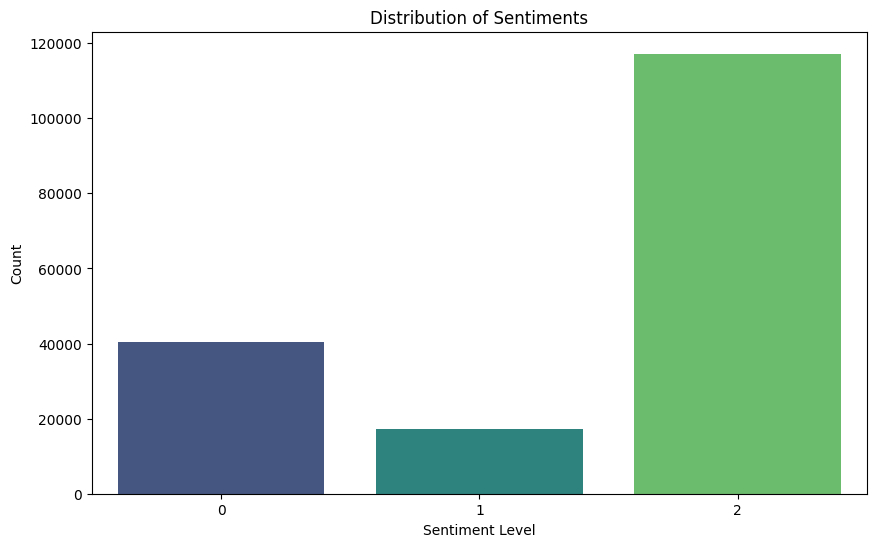

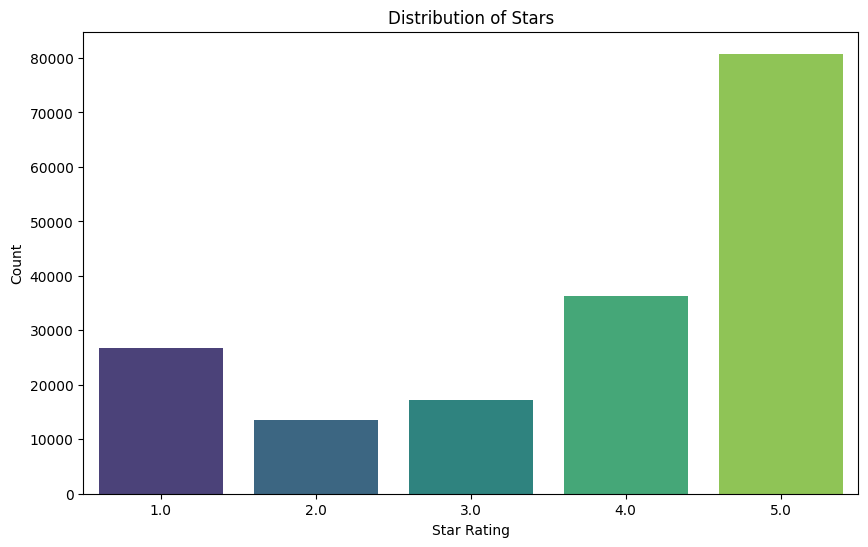

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

tokenizer = get_tokenizer('basic_english')

# preprocess text which basically removes stopwords, lower case all words and remove punctuations
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = tokenizer(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in tokens if word not in stop_words]
    return ' '.join(tokens)

def seq_length(texts):
    return len(tokenizer(texts))



# Load train and testDataset
dataset_path = r"yelp_review_train.csv"
test_dataset_path = r"yelp_review_test.csv"
df = pd.read_csv(dataset_path, encoding='utf-8')
print(df.head())
test_data = pd.read_csv(test_dataset_path)

# Apply pre-processing to the 'text' column in train and test data
df['text'] = df['text'].apply(preprocess_text)
test_data['text']=test_data['text'].apply(preprocess_text)

def convert_stars(stars):
    if stars > 3:
        return 2
    elif stars <= 2:
        return 0
    else:
        return 1


# Convert stars into three levels
df['sentiment'] = df['stars'].apply(convert_stars)
test_data['sentiment']=test_data['stars'].apply(convert_stars)

df['seq_length']=df['text'].apply(seq_length)
print("Data after preprocessing:")
print(df.head())

# plot distribution for better understanding of data
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment Level')
plt.ylabel('Count')
plt.show()

# Plot the Distribution of stars
plt.figure(figsize=(10, 6))
sns.countplot(x='stars', data=df, palette='viridis')
plt.title('Distribution of Stars')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()

These distributions indicate a lack of uniformity and bias in the data, particularly towards 5-rated reviews. This imbalance may pose challenges in constructing a robust model.

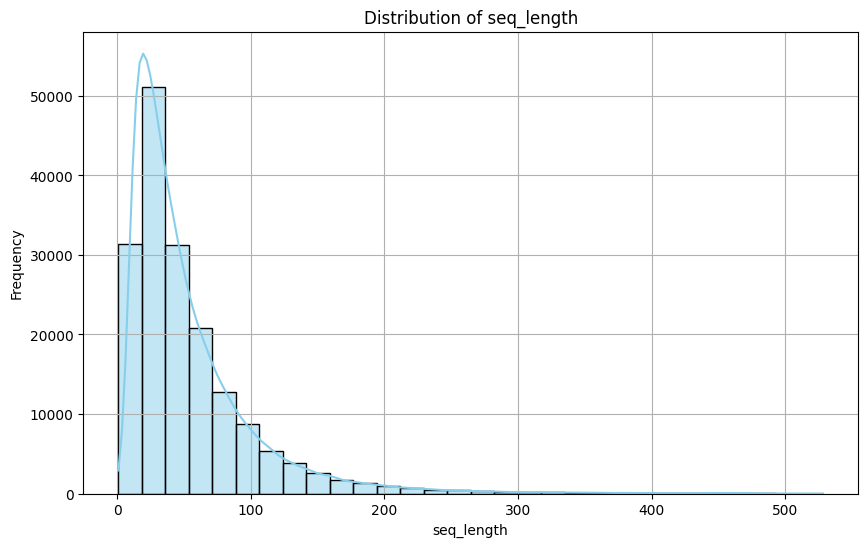

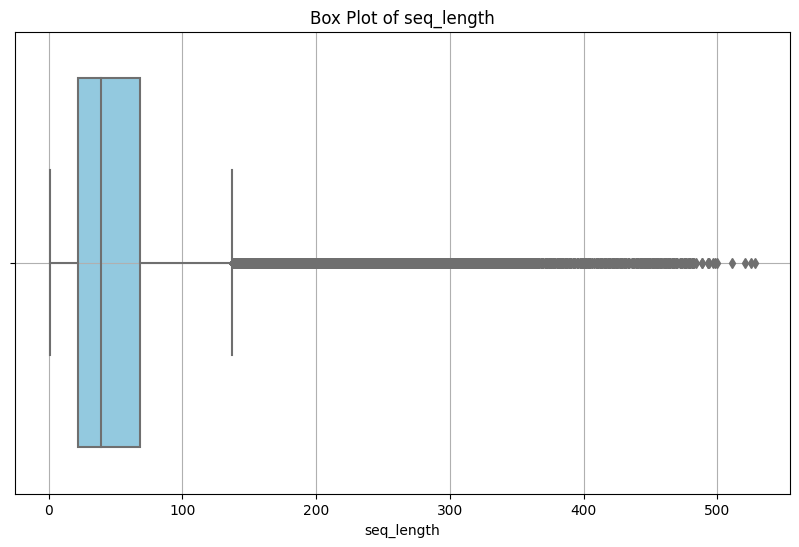

The 95th percentile of seq_length is: 147.0


In [5]:
column_name = 'seq_length'
plt.figure(figsize=(10, 6))
sns.histplot(df[column_name], bins=30, kde=True, color='skyblue')
plt.title(f'Distribution of {column_name}')
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
sns.boxplot(x=df[column_name], color='skyblue')
plt.title(f'Box Plot of {column_name}')
plt.xlabel(column_name)
plt.grid(True)
plt.show()

quantile_95 = df[column_name].quantile(0.95)

print(f'The 95th percentile of {column_name} is: {quantile_95}')

The optimal choice for the sequence length is determined by analyzing both the histogram and box plot. With 95% of the data falling below a sequence length of 147, this length is identified as the optimal selection.

# Input Data Prepration

In [7]:
class InputPreperation:
  def __init__(self):
    self.tokenizer=BertTokenizerFast.from_pretrained('bert-base-uncased')

  def yelp_data_loader(self,data, target, max_seq_len, batch_size):
    tokens = self.tokenizer.batch_encode_plus(
        data.tolist(),
        max_length = max_seq_len,
        pad_to_max_length=True,
        truncation=True,
        return_token_type_ids=False
    )
    seq = torch.tensor(tokens['input_ids']).to(device)
    mask = torch.tensor(tokens['attention_mask']).to(device)
    y = torch.tensor(target.tolist()).to(device)


    # wrap tensors
    dataset = TensorDataset(seq, mask, y)

    # dataLoader for train set
    dataloader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=batch_size)

    return dataloader

In [8]:
# split the train data into train data validation data
train_text, val_text, train_sentiment, val_sentiment = train_test_split(
    df['text'], df['sentiment'], random_state=9, test_size=0.1
)

In [9]:
# create data loaders using Input Preperation class
inputPreperation=InputPreperation()
max_seq_len = 147
batch=32
train_dataloader=inputPreperation.yelp_data_loader(train_text,train_sentiment,max_seq_len,batch)
valid_dataloader=inputPreperation.yelp_data_loader(val_text,val_sentiment,max_seq_len,batch)
test_dataloader=inputPreperation.yelp_data_loader(test_data['text'],test_data['sentiment'],max_seq_len,batch)

# Model Implementation

In [10]:
# load the bert base uncased pretrained model for fine tuning on yelp reviews.
bert = AutoModel.from_pretrained('bert-base-uncased')

In [11]:
# Transformer Architecture for classifying the yelp reviews
class TransformerArchitecture(nn.Module):
    def __init__(self, bert, lstm_hidden_size=128, num_lstm_layers=1):
        super(TransformerArchitecture, self).__init__()
        self.bert = bert
        
        self.dropout = nn.Dropout(0.3)
        
        self.lstm = nn.LSTM(input_size=bert.config.hidden_size, hidden_size=lstm_hidden_size,
                            num_layers=num_lstm_layers, batch_first=True, bidirectional=False)
        
        self.fc1 = nn.Linear(147*lstm_hidden_size, 256)
        
        self.fc2 = nn.Linear(256, 64)
        
        self.fc3 = nn.Linear(64, 3)
    def forward(self, sent_id, mask):
        cls_hs = self.bert(sent_id, attention_mask=mask)
        
        all_hidden_states = cls_hs.last_hidden_state  
        
        
        lstm_out, _ = self.lstm(all_hidden_states)
        
        lstm_out_flat = lstm_out.reshape(-1, lstm_out.size(2) * lstm_out.size(1))
        
        
        x = self.fc1(lstm_out_flat)
        x = self.dropout(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        x = self.fc3(x)

        return x

In [12]:
# intialize the model with bert.
def initialize_model(bert, device):
    model = TransformerArchitecture(bert)
    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
    cross_entropy = nn.CrossEntropyLoss()
    return model, optimizer, cross_entropy

epochs = 5
model, optimizer, cross_entropy = initialize_model(bert, device)

# Model Training

Trainer class helps to load required data and tries to train the model over the data

In [13]:
class Trainer:
    def __init__(self, model, optimizer, criterion, train_dataloader, device):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_dataloader = train_dataloader
        self.device = device
    # train the model for an epocjh
    def run_training_epoch(self):
        self.model.train()

        total_loss, total_accuracy = 0, 0

        all_predictions, all_labels = [], []

        progress_bar = tqdm(enumerate(self.train_dataloader), total=len(self.train_dataloader), desc="Training")
        
        # go over different batches and train the model accordingly
        for step, batch in progress_bar:

            batch = [r.to(self.device) for r in batch]

            input_ids, attention_mask, labels = batch

            predictions = self.model(input_ids, attention_mask)

            loss = self.criterion(predictions, labels)

            total_loss += loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

            self.optimizer.step()

            self.optimizer.zero_grad()

            predictions = predictions.detach().cpu().numpy()

            all_predictions.append(predictions)
            all_labels.append(labels.cpu().numpy())

            progress_bar.set_postfix({'Loss': total_loss / (step + 1)})

        average_loss = total_loss / len(self.train_dataloader)

        all_predictions = np.concatenate(all_predictions, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

        accuracy = accuracy_score(all_labels, np.argmax(all_predictions, axis=1))

        print(f"Training Accuracy: {accuracy * 100:.2f}%")

        return average_loss, accuracy

trainer = Trainer(model, optimizer, cross_entropy, train_dataloader, device)


Evaluator class helps in evaluating the test or validation data

In [14]:
class Evaluator:
    def __init__(self, model, dataloader, criterion, device):
        self.model = model
        self.dataloader = dataloader
        self.criterion = criterion
        self.device = device
    
    # evaluate method helps in evaluating the test data. It returns avg loss and accuracy over the different batches.
    def evaluate(self):
        self.model.eval()

        total_loss, total_correct, total_samples = 0, 0, 0

        progress_bar = tqdm(enumerate(self.dataloader), total=len(self.dataloader), desc="Evaluating")

        for step, batch in progress_bar:

            batch = [t.to(self.device) for t in batch]

            sent_id, mask, labels = batch

            with torch.no_grad():

                predictions = self.model(sent_id, mask)

                loss = self.criterion(predictions, labels)

                total_loss += loss.item()

                predictions = torch.argmax(predictions, axis=1)
                total_correct += torch.sum(predictions == labels).item()
                total_samples += len(labels)

                predictions = predictions.detach().cpu().numpy()

        avg_loss = total_loss / len(self.dataloader)

        accuracy = total_correct / total_samples

        return avg_loss, accuracy

evaluator = Evaluator(model, valid_dataloader, cross_entropy, device)


In [15]:
best_valid_loss = float('inf')

# Lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []
train_accuracy_list = []
valid_accuracy_list = []

for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1}/{epochs}')

    # Train the model
    train_loss, train_accuracy = trainer.run_training_epoch()

    # Evaluate the model
    valid_loss, valid_accuracy = evaluator.evaluate()

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_weights_new4.pt')

    # Append training and validation loss, and training and validation accuracy
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracy_list.append(train_accuracy)
    valid_accuracy_list.append(valid_accuracy)

    print(f'Training Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'Training Accuracy: {train_accuracy:.3f}')
    print(f'Validation Accuracy: {valid_accuracy:.3f}')




Epoch 1/5


Training: 100%|██████████| 4916/4916 [35:45<00:00,  2.29it/s, Loss=0.35] 


Training Accuracy: 87.10%


Evaluating: 100%|██████████| 547/547 [01:17<00:00,  7.04it/s]


Training Loss: 0.350
Validation Loss: 0.304
Training Accuracy: 0.871
Validation Accuracy: 0.887

Epoch 2/5


Training: 100%|██████████| 4916/4916 [35:49<00:00,  2.29it/s, Loss=0.262]


Training Accuracy: 90.40%


Evaluating: 100%|██████████| 547/547 [01:17<00:00,  7.02it/s]


Training Loss: 0.262
Validation Loss: 0.297
Training Accuracy: 0.904
Validation Accuracy: 0.893

Epoch 3/5


Training: 100%|██████████| 4916/4916 [35:48<00:00,  2.29it/s, Loss=0.202]


Training Accuracy: 92.69%


Evaluating: 100%|██████████| 547/547 [01:17<00:00,  7.04it/s]


Training Loss: 0.202
Validation Loss: 0.323
Training Accuracy: 0.927
Validation Accuracy: 0.890

Epoch 4/5


Training: 100%|██████████| 4916/4916 [35:46<00:00,  2.29it/s, Loss=0.15] 


Training Accuracy: 94.89%


Evaluating: 100%|██████████| 547/547 [01:17<00:00,  7.04it/s]


Training Loss: 0.150
Validation Loss: 0.406
Training Accuracy: 0.949
Validation Accuracy: 0.882

Epoch 5/5


Training: 100%|██████████| 4916/4916 [35:48<00:00,  2.29it/s, Loss=0.116]


Training Accuracy: 96.35%


Evaluating: 100%|██████████| 547/547 [01:17<00:00,  7.05it/s]

Training Loss: 0.116
Validation Loss: 0.495
Training Accuracy: 0.963
Validation Accuracy: 0.879


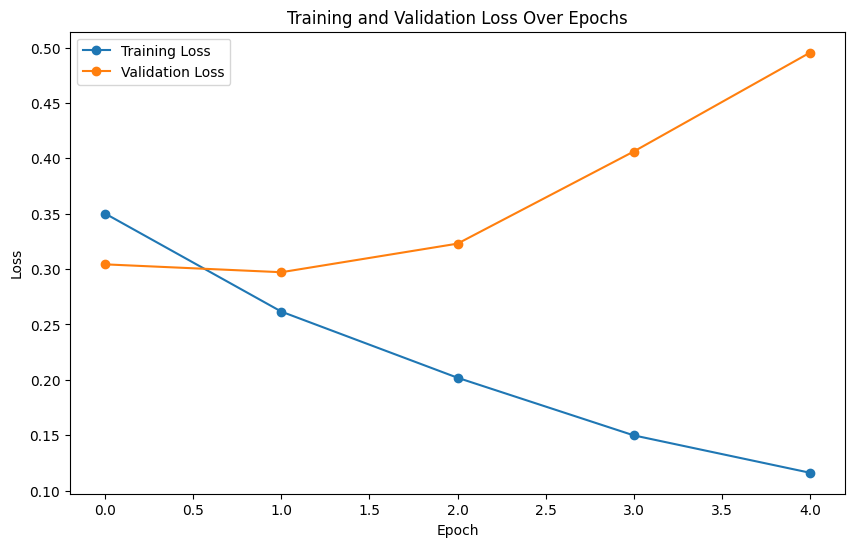

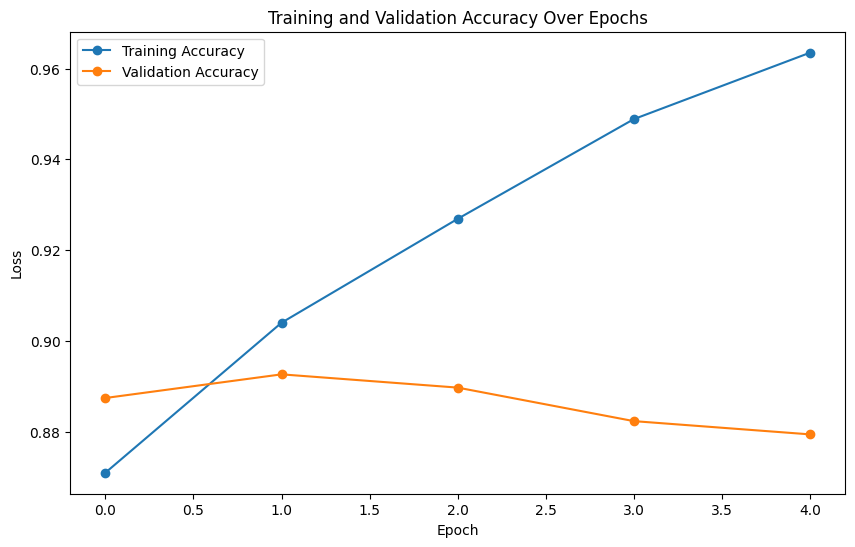

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(valid_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(train_accuracy_list, label='Training Accuracy', marker='o')
plt.plot(valid_accuracy_list, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

The training loss consistently decreases from 0.35 to 0.116, indicating improved predictive performance on the training data. Concurrently, training accuracy rises from 87.10% to 96.35%, reflecting the model's learning. However, there is a slight increase in validation loss from 0.297 to 0.495, suggesting potential overfitting, where the model may not generalize well to new data.

# Result Analysis

Evaluating: 100%|██████████| 437/437 [01:01<00:00,  7.06it/s]


Accuracy: 0.893
Confusion Matrix:
[[2828  167  150]
 [ 348  549  519]
 [ 113  197 9109]]
Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.90      0.88      3145
     Neutral       0.60      0.39      0.47      1416
    Positive       0.93      0.97      0.95      9419

    accuracy                           0.89     13980
   macro avg       0.80      0.75      0.77     13980
weighted avg       0.88      0.89      0.88     13980



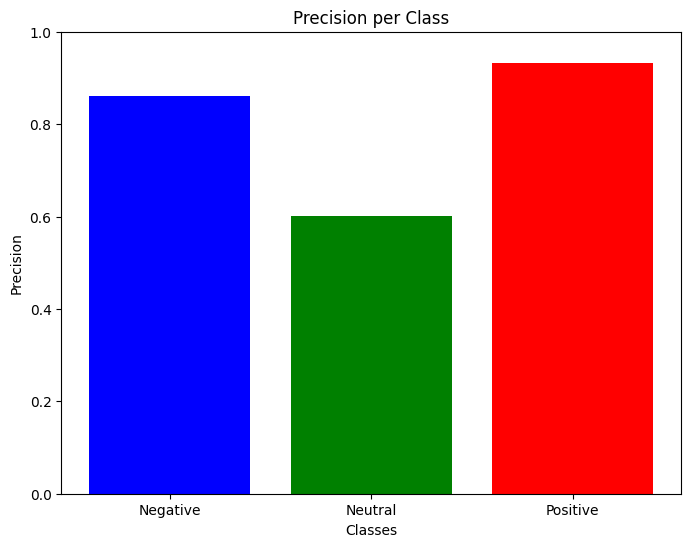

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix

model,_,_ = initialize_model(bert, device)
model.load_state_dict(torch.load('model_weights_new4.pt'))
model.eval()  # Set the model to evaluation mode

progress_bar = tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc="Evaluating")
all_true_labels = []
all_predicted_labels = []

# Iterate over batches
for step, batch in progress_bar:
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    with torch.no_grad():
        predictions = model(sent_id, mask)

        predictions = torch.argmax(predictions, axis=1).cpu().numpy()

        # Append true and predicted labels for confusion matrix calculation
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predictions)

# Calculate and print accuracy
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
print(f'Accuracy: {accuracy:.3f}')

# Calculate and print confusion matrix
cm = confusion_matrix(all_true_labels, all_predicted_labels)
print('Confusion Matrix:')
print(cm)

report = classification_report(all_true_labels, all_predicted_labels, target_names=['Negative', 'Neutral','Positive'], output_dict=True)

# Print classification report
print('Classification Report:')
print( classification_report(all_true_labels, all_predicted_labels, target_names=['Negative', 'Neutral','Positive']))

# Plotting accuracy per class
accuracy_per_class = [report[label]['precision'] for label in ['Negative', 'Neutral','Positive']]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(['Negative', 'Neutral','Positive'], accuracy_per_class, color=['blue', 'green', 'red'])
plt.title('Precision per Class')
plt.xlabel('Classes')
plt.ylabel('Precision')
plt.ylim(0, 1)  # Set the y-axis limit between 0 and 1 for precision percentage
plt.show()

The model achieved an overall accuracy of 89.3% on the test dataset. The confusion matrix reveals that the model performed well in correctly classifying positive reviews (9109 out of 9419) but struggled more with neutral reviews, achieving a precision of 60% and recall of 39%. The classification report provides additional insights, indicating strong precision, recall, and F1-score for both negative and positive sentiments, while neutral sentiment classification lags behind. The weighted average metrics underscore an overall good performance, with an accuracy of 88%.

# Result Analysis: Impact of number of hidden layers and number of attention heads on Transformers

The hyperparameters, specifically the hidden dimension and the number of attention heads, have good influence over the Transformer architecture. The hidden dimension, determining the size of hidden layers, directly impacts the model's capacity to capture intricate patterns. While a larger dimension may enhance feature learning, it can lead to overfitting, and a smaller dimension may result in underfitting. On the other hand, the number of attention layers plays a crucial role in the model's ability to capture long-range dependencies in input sequences. A higher number improves expressiveness but introduces computational complexity, necessitating a careful balance between model complexity and efficiency.
Certainly, here's the modified statement:

So, using a custom BERT architecture, I have fine-tuned the model to understand the impact on model performance. The custom architecture involves adjustments to hyperparameters such as the hidden dimension and the number of attention layers.

In [23]:
import torch.nn.functional as F
from torch.nn import BatchNorm1d

class TransformerCustomArchitecture(nn.Module):
    def __init__(self, bert, lstm_hidden_size=128, num_lstm_layers=1):
        super(TransformerCustomArchitecture, self).__init__()

        self.bert = bert
        self.dropout = nn.Dropout(0.3)

        self.lstm = nn.LSTM(input_size=bert.config.hidden_size, hidden_size=lstm_hidden_size,
                            num_layers=num_lstm_layers, batch_first=True, bidirectional=False)

        self.fc1 = nn.Linear(147*lstm_hidden_size, 256)

        self.fc2 = nn.Linear(256, 64)

        self.fc3 = nn.Linear(64, 3)

    def forward(self, sent_id, mask):
        output = self.bert(sent_id, attention_mask=mask)

        lstm_out, _ = self.lstm(output)
        lstm_out_flat = lstm_out.reshape(-1, lstm_out.size(2) * lstm_out.size(1))
        x = self.fc1(lstm_out_flat)
        x = self.dropout(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = self.dropout(x)
        x = F.relu(x)

        x = self.fc3(x)

        return x

def initialize_model_custom(bert, device):
    model = TransformerCustomArchitecture(bert)
    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

    cross_entropy = nn.CrossEntropyLoss()

    return model, optimizer, cross_entropy

from transformers import BertModel, BertConfig

class CustomBertModel(nn.Module):
    def __init__(self, num_encoder_layers, num_attention_heads, pretrained_model_name='bert-base-uncased'):
        super(CustomBertModel, self).__init__()

        # Load the pre-trained BERT model configuration
        self.config = BertConfig.from_pretrained(pretrained_model_name)

        # Modify the number of encoder layers and attention heads in the configuration
        self.config.num_hidden_layers = num_encoder_layers
        self.config.num_attention_heads = num_attention_heads

        # Load the modified BERT model
        self.bert = BertModel.from_pretrained(pretrained_model_name, config=self.config)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  



Epoch 1/3


Training: 100%|██████████| 844/844 [02:04<00:00,  6.80it/s, Loss=0.443]


Training Accuracy: 83.81%


Evaluating: 100%|██████████| 94/94 [00:04<00:00, 21.06it/s]


Training Loss: 0.443
Validation Loss: 0.372
Training Accuracy: 0.838
Validation Accuracy: 0.854

Epoch 2/3


Training: 100%|██████████| 844/844 [02:04<00:00,  6.75it/s, Loss=0.324]


Training Accuracy: 88.07%


Evaluating: 100%|██████████| 94/94 [00:04<00:00, 21.05it/s]


Training Loss: 0.324
Validation Loss: 0.372
Training Accuracy: 0.881
Validation Accuracy: 0.865

Epoch 3/3


Training: 100%|██████████| 844/844 [02:04<00:00,  6.75it/s, Loss=0.253]


Training Accuracy: 90.62%


Evaluating: 100%|██████████| 94/94 [00:04<00:00, 21.05it/s]


Training Loss: 0.253
Validation Loss: 0.385
Training Accuracy: 0.906
Validation Accuracy: 0.870
Avg Time taken for training: 124.74 seconds


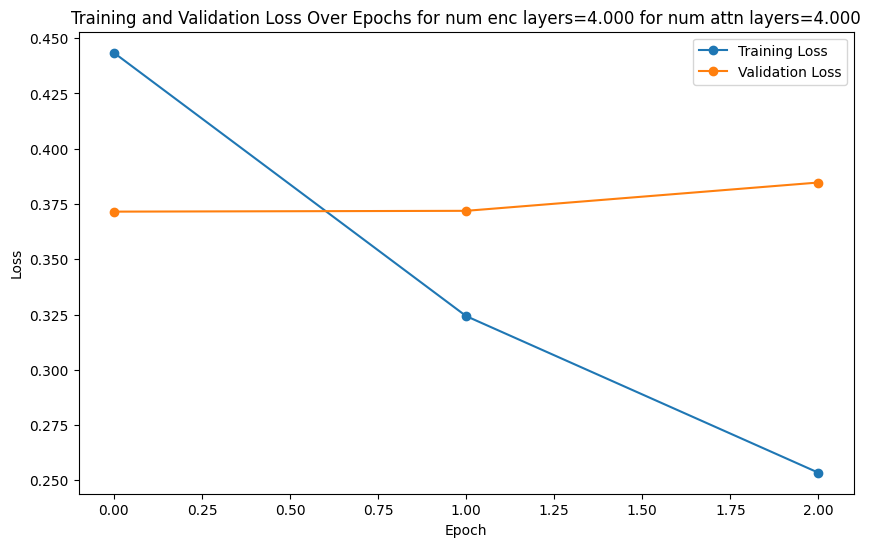

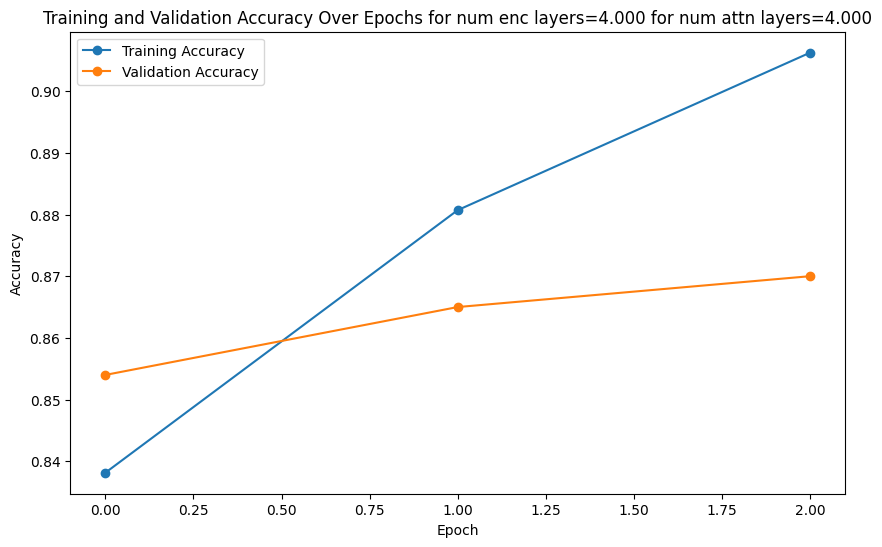


Epoch 1/3


Training: 100%|██████████| 844/844 [02:06<00:00,  6.67it/s, Loss=0.446]


Training Accuracy: 83.73%


Evaluating: 100%|██████████| 94/94 [00:04<00:00, 20.79it/s]


Training Loss: 0.446
Validation Loss: 0.358
Training Accuracy: 0.837
Validation Accuracy: 0.863

Epoch 2/3


Training: 100%|██████████| 844/844 [02:06<00:00,  6.66it/s, Loss=0.32] 


Training Accuracy: 87.92%


Evaluating: 100%|██████████| 94/94 [00:04<00:00, 20.72it/s]


Training Loss: 0.320
Validation Loss: 0.354
Training Accuracy: 0.879
Validation Accuracy: 0.866

Epoch 3/3


Training: 100%|██████████| 844/844 [02:06<00:00,  6.67it/s, Loss=0.253]


Training Accuracy: 90.49%


Evaluating: 100%|██████████| 94/94 [00:04<00:00, 20.76it/s]


Training Loss: 0.253
Validation Loss: 0.405
Training Accuracy: 0.905
Validation Accuracy: 0.871
Avg Time taken for training: 126.59 seconds


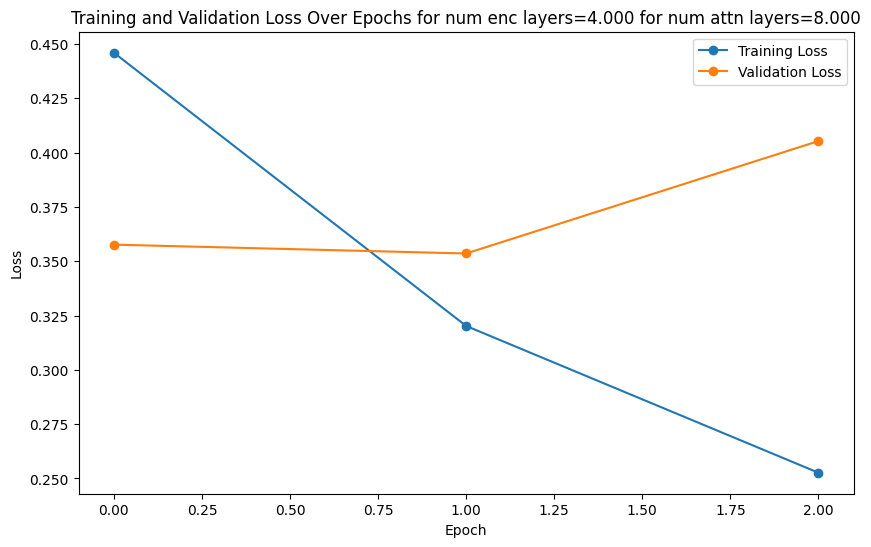

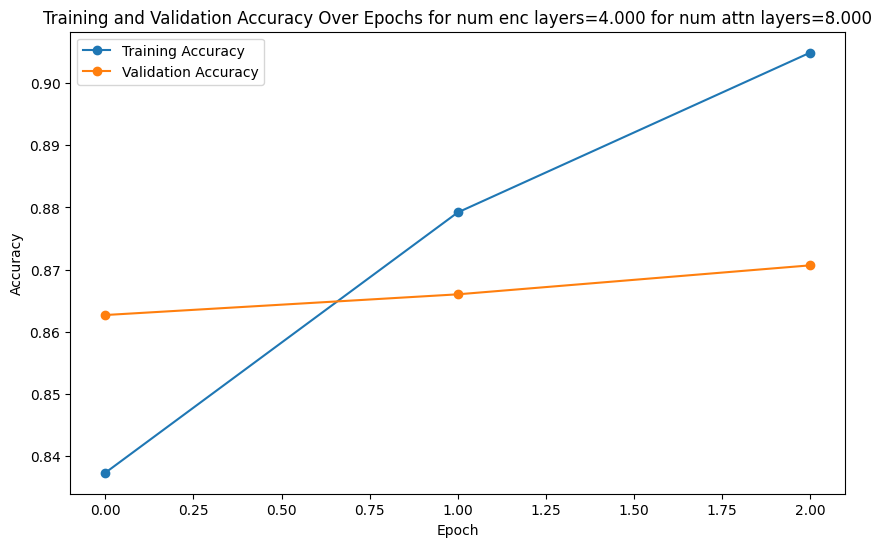


Epoch 1/3


Training: 100%|██████████| 844/844 [03:59<00:00,  3.52it/s, Loss=0.444]


Training Accuracy: 83.67%


Evaluating: 100%|██████████| 94/94 [00:08<00:00, 10.90it/s]


Training Loss: 0.444
Validation Loss: 0.359
Training Accuracy: 0.837
Validation Accuracy: 0.863

Epoch 2/3


Training: 100%|██████████| 844/844 [03:59<00:00,  3.52it/s, Loss=0.317]


Training Accuracy: 88.19%


Evaluating: 100%|██████████| 94/94 [00:08<00:00, 10.88it/s]


Training Loss: 0.317
Validation Loss: 0.368
Training Accuracy: 0.882
Validation Accuracy: 0.865

Epoch 3/3


Training: 100%|██████████| 844/844 [04:00<00:00,  3.52it/s, Loss=0.243]


Training Accuracy: 91.07%


Evaluating: 100%|██████████| 94/94 [00:08<00:00, 10.88it/s]


Training Loss: 0.243
Validation Loss: 0.379
Training Accuracy: 0.911
Validation Accuracy: 0.869
Avg Time taken for training: 239.91 seconds


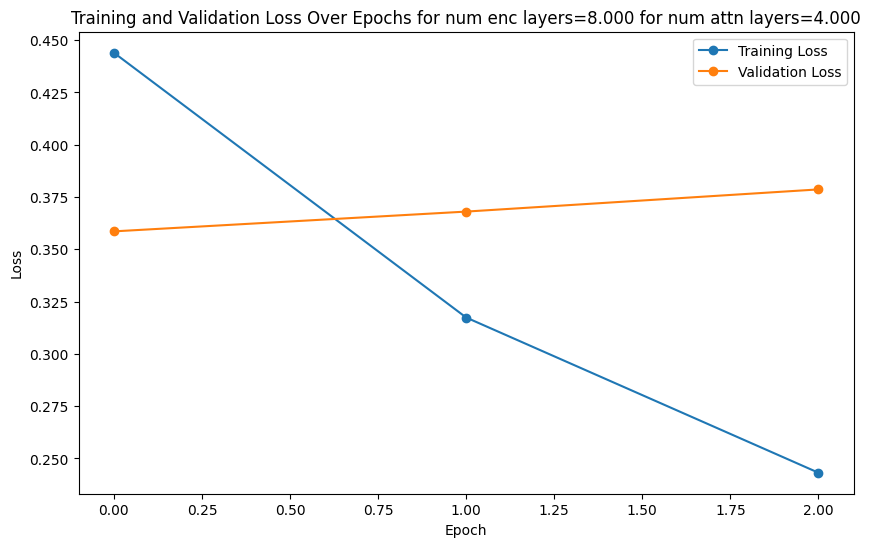

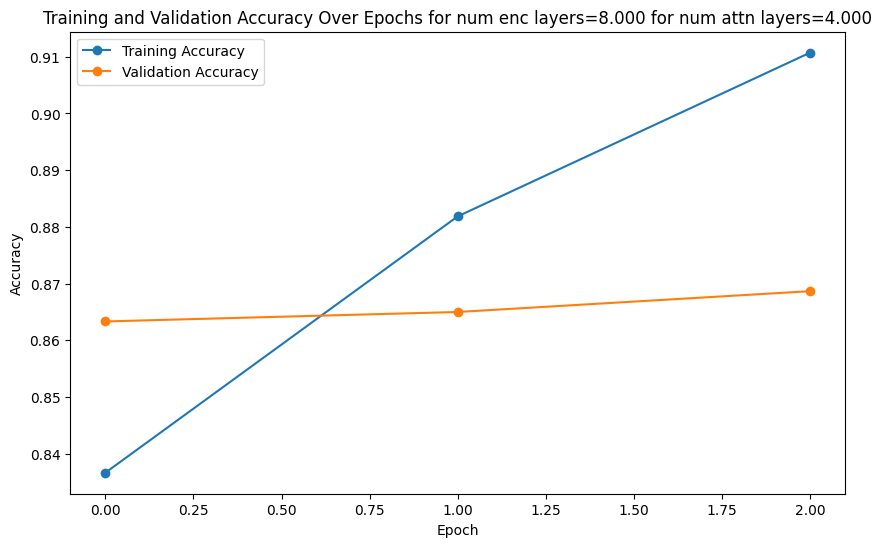


Epoch 1/3


Training: 100%|██████████| 844/844 [04:03<00:00,  3.47it/s, Loss=0.445]


Training Accuracy: 83.80%


Evaluating: 100%|██████████| 94/94 [00:08<00:00, 10.72it/s]


Training Loss: 0.445
Validation Loss: 0.341
Training Accuracy: 0.838
Validation Accuracy: 0.871

Epoch 2/3


Training: 100%|██████████| 844/844 [04:03<00:00,  3.46it/s, Loss=0.31] 


Training Accuracy: 88.46%


Evaluating: 100%|██████████| 94/94 [00:08<00:00, 10.76it/s]


Training Loss: 0.310
Validation Loss: 0.337
Training Accuracy: 0.885
Validation Accuracy: 0.872

Epoch 3/3


Training: 100%|██████████| 844/844 [04:03<00:00,  3.47it/s, Loss=0.234]


Training Accuracy: 91.52%


Evaluating: 100%|██████████| 94/94 [00:08<00:00, 10.75it/s]


Training Loss: 0.234
Validation Loss: 0.396
Training Accuracy: 0.915
Validation Accuracy: 0.875
Avg Time taken for training: 243.51 seconds


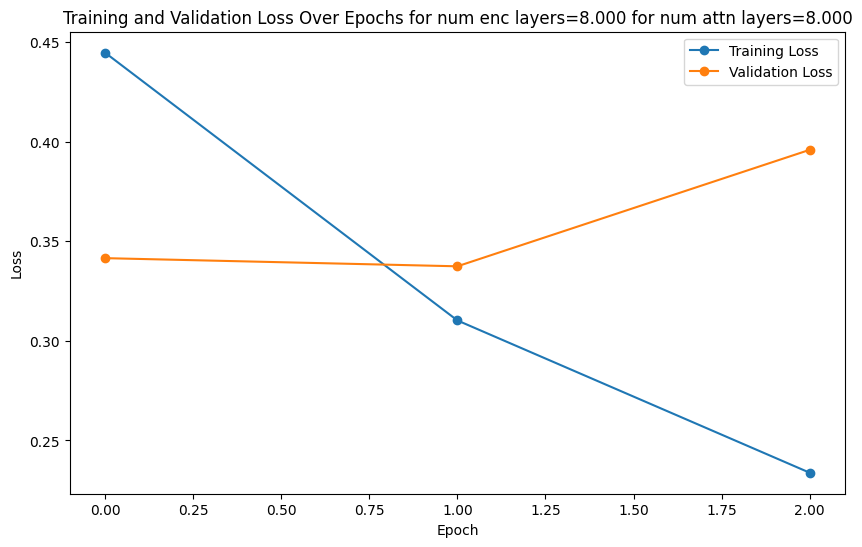

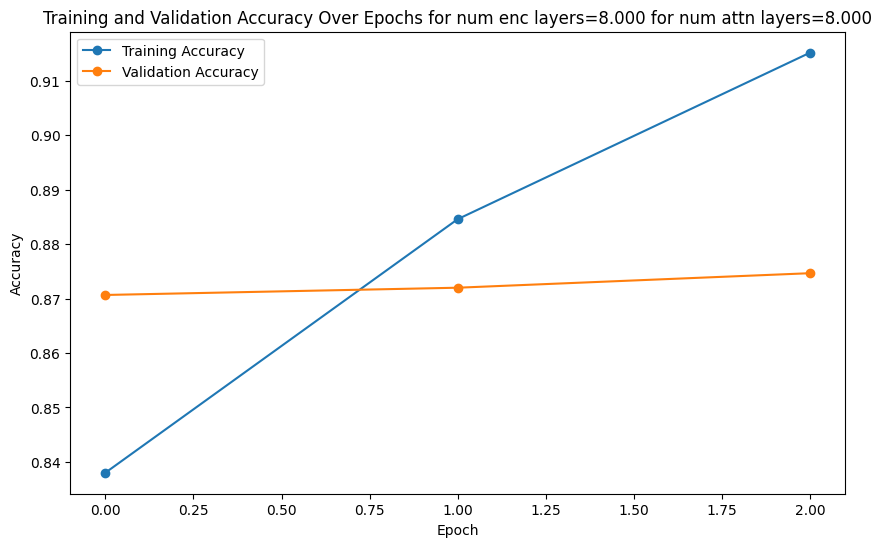

In [24]:
import time

num_encoder_layers_list = [4, 8]
num_attention_heads_list = [4, 8]

val_acc_over_diff_models = {}

# training the custom models with a smaller dataset.
train_text_custom, val_text_custom, train_sentiment_custom, val_sentiment_custom = train_test_split(
    df['text'][:30000], df['sentiment'][:30000], random_state=9, test_size=0.1
)

train_dataloader_custom=inputPreperation.yelp_data_loader(train_text_custom,train_sentiment_custom,max_seq_len,32)
valid_dataloader_custom=inputPreperation.yelp_data_loader(val_text_custom,val_sentiment_custom,max_seq_len,32)

for i in num_encoder_layers_list:
    for j in num_attention_heads_list:
        num_encoder_layers = i
        num_attention_heads = j
        custom_bert_model = CustomBertModel(num_encoder_layers, num_attention_heads)
        custom_model, optimizer, cross_entropy = initialize_model_custom(custom_bert_model, device)
        trainer_custom = Trainer(custom_model, optimizer, cross_entropy, train_dataloader_custom, device)
        evaluator_custom = Evaluator(custom_model, valid_dataloader_custom, cross_entropy, device)

        best_valid_loss = float('inf')

        # Lists to store training and validation loss of each epoch
        train_losses = []
        valid_losses = []
        train_accuracy_list = []
        valid_accuracy_list = []
            
        total_time_list=[]
        for epoch in range(3):
            print(f'\nEpoch {epoch + 1}/{3}')
            
            start_time = time.time() 
            # Train the model
            train_loss, train_accuracy = trainer_custom.run_training_epoch()
            end_time = time.time()
            # Evaluate the model
            valid_loss, valid_accuracy = evaluator_custom.evaluate()

            # Save the best model
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(custom_model.state_dict(), '/kaggle/working/model_weights.pt')

            # Append training and validation loss
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            train_accuracy_list.append(train_accuracy)
            valid_accuracy_list.append(valid_accuracy)
            total_time_list.append(end_time - start_time)

            print(f'Training Loss: {train_loss:.3f}')
            print(f'Validation Loss: {valid_loss:.3f}')
            print(f'Training Accuracy: {train_accuracy:.3f}')
            print(f'Validation Accuracy: {valid_accuracy:.3f}')

          # Record the end time
        print(f"Avg Time taken for training: {sum(total_time_list)/3:.2f} seconds")

        val_acc_over_diff_models[(num_encoder_layers, num_attention_heads)] = (best_valid_loss,sum(total_time_list)/3,max(valid_accuracy_list))

        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss', marker='o')
        plt.plot(valid_losses, label='Validation Loss', marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training and Validation Loss Over Epochs for num enc layers={num_encoder_layers:.3f} for num attn layers={num_attention_heads:.3f}')
        plt.legend()
        plt.show()


        plt.figure(figsize=(10, 6))
        plt.plot(train_accuracy_list, label='Training Accuracy', marker='o')
        plt.plot(valid_accuracy_list, label='Validation Accuracy', marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(f'Training and Validation Accuracy Over Epochs for num enc layers={num_encoder_layers:.3f} for num attn layers={num_attention_heads:.3f}')
        plt.legend()
        plt.show()

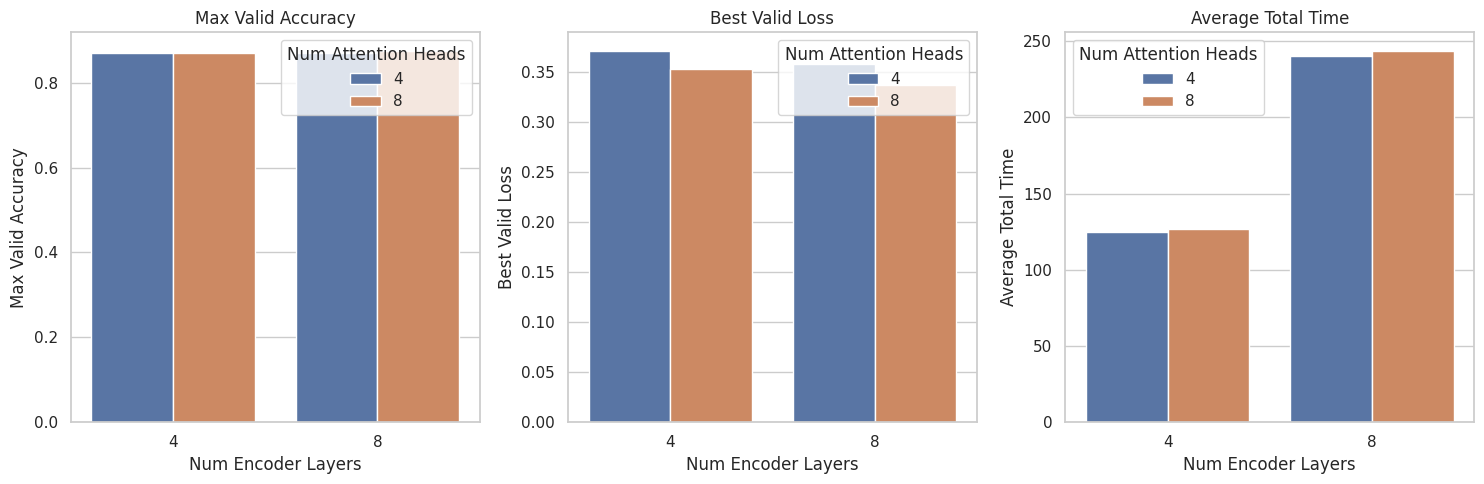

In [26]:
data = pd.DataFrame(list(val_acc_over_diff_models.values()), columns=['Best Valid Loss', 'Average Total Time', 'Max Valid Accuracy'])
data[['Num Encoder Layers', 'Num Attention Heads']] = pd.DataFrame(list(val_acc_over_diff_models.keys()))

# Set up the Seaborn figure
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 3, 1)
sns.barplot(x='Num Encoder Layers', y='Max Valid Accuracy', hue='Num Attention Heads', data=data)
plt.title('Max Valid Accuracy')

# Plot Loss
plt.subplot(1, 3, 2)
sns.barplot(x='Num Encoder Layers', y='Best Valid Loss', hue='Num Attention Heads', data=data)
plt.title('Best Valid Loss')

# Plot Time
plt.subplot(1, 3, 3)
sns.barplot(x='Num Encoder Layers', y='Average Total Time', hue='Num Attention Heads', data=data)
plt.title('Average Total Time')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Fine-tuning the BERT model with varying numbers of encoder layers and attention heads surprisingly has minimal impact on the model's accuracy. However, there is a significant reduction in the average training time, indicating potential efficiency improvements in the model training process.